In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump
import logging
import json
import seaborn as sns

In [2]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
# Load the CSV file into a pandas DataFrame
try:
    df = pd.read_csv("datafiles/property_tag.csv")
except FileNotFoundError as e:
    logger.error("File not found: %s", e)
    raise
except pd.errors.EmptyDataError as e:
    logger.error("File is empty: %s", e)
    raise

In [4]:
print(df.columns)

Index(['system_ind', 'tag', 'num_vertices', 'iso_q', 'fractal', 'eri',
       'convexity', 'area_in_me', 'corners', 'average_distance',
       'neighbors_within_50m', 'first_neighbor', 'distance_to_nearest_road',
       'centroid_elevation', 'orientation', 'street_alignment', 'ccd_means',
       'ccd_stdev', 'cwa', 'elongation', 'squ_comp', 'squareness', 'perimeter',
       'average_alignment', 'first_neighbor_alignment'],
      dtype='object')


In [5]:
scaler = StandardScaler()

# Define the features (independent variables) and the target (dependent variable)
X = df[
    [
        "num_vertices",
        "iso_q",
        "fractal",
        "eri",
        "convexity",
        "area_in_me",
        "corners",
        "average_distance",
        "neighbors_within_50m",
        "first_neighbor",
        "distance_to_nearest_road",
        "centroid_elevation",
        "orientation",
        "street_alignment",
        "ccd_means",
        "ccd_stdev",
        "cwa",
        "elongation",
        "squ_comp",
        "squareness",
        "perimeter",
        "average_alignment",
        "first_neighbor_alignment",
    ]
]

y = df["tag"]

# Split the data into training and testing sets[^1^][1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

X_train_original = X_train

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [7]:
means = scaler.mean_
std_devs = np.sqrt(scaler.var_)

statistics = pd.DataFrame({
    'Feature': X.columns,
    'Mean': means,
    'Standard Deviation': std_devs
})

statistics.to_csv('datafiles/means_and_stds.csv', index=False)

In [ ]:
print(X_train_original)

In [6]:
dump(X_train_original, 'datafiles/results/Random Forest/random_forest_X_train_original.joblib')

dump(X_train, 'datafiles/results/Random Forest/random_forest_X_train.joblib')

dump(y_train, 'datafiles/results/Random Forest/random_forest_y_train.joblib')

['datafiles/results/Random Forest/random_forest_y_train.joblib']

In [7]:
# Create a Random Forest classifier[^2^][2]
clf = RandomForestClassifier(random_state=42)

In [8]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 40, 80, 100],
    'max_features': [None, 'sqrt', "log2"],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [12, 15, 20],
    'n_estimators': [50, 100, 300, 1000]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", verbose=3, n_jobs=-1)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best estimator (model) from the grid search
best_clf = grid_search.best_estimator_

logger.info("Best hyperparameters according to grid search: %s", grid_search.best_params_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


INFO:__main__:Best hyperparameters according to grid search: {'bootstrap': True, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 20, 'n_estimators': 300}


In [9]:
# Evaluate feature importance using RFE with cross-validation
def evaluate_rfe(n_features):
    rfe = RFE(estimator=best_clf, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    X_train_rfe = rfe.transform(X_train)
    scores = cross_val_score(best_clf, X_train_rfe, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
    return scores.mean()

# Evaluate performance for different numbers of features
num_features = list(range(1, X.shape[1] + 1))
scores = [evaluate_rfe(n) for n in num_features]

# Find the optimal number of features
optimal_num_features = num_features[np.argmax(scores)]
logger.info(f"Optimal number of features: {optimal_num_features}")
logger.info(f"Best cross-validation accuracy: {max(scores)}")

INFO:__main__:Optimal number of features: 12
INFO:__main__:Best cross-validation accuracy: 0.6709132276243481


In [10]:
# Fit the model with the optimal number of features
rfe = RFE(estimator=best_clf, n_features_to_select=optimal_num_features)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Refit the best model on the reduced feature set
best_clf.fit(X_train_rfe, y_train)
y_pred = best_clf.predict(X_test_rfe)

# Calculate the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
logger.info("Best model accuracy: %.2f%%", accuracy * 100)

INFO:__main__:Best model accuracy: 69.13%


In [11]:
# Cross-validation scores
cv_scores = cross_val_score(best_clf, X_train_rfe, y_train, cv=5)
logger.info("Cross-validation scores: %s", cv_scores)
logger.info("Mean cross-validation score: %.2f%%", cv_scores.mean() * 100)

# Per-class evaluation
class_report = classification_report(y_test, y_pred, target_names=best_clf.classes_.astype(str), zero_division=1)
logger.info("Classification Report:\n%s", class_report)

INFO:__main__:Cross-validation scores: [0.64299065 0.65046729 0.68037383 0.70093458 0.66292135]
INFO:__main__:Mean cross-validation score: 66.75%
INFO:__main__:Classification Report:
              precision    recall  f1-score   support

      Tier 1       1.00      0.00      0.00        20
      Tier 2       0.66      0.56      0.61       141
      Tier 3       0.69      0.89      0.78       196
      Tier 4       0.73      0.63      0.68       116

    accuracy                           0.69       473
   macro avg       0.77      0.52      0.52       473
weighted avg       0.70      0.69      0.67       473



INFO:__main__:Confusion Matrix:
[[  0  14   5   1]
 [  0  79  45  17]
 [  0  12 175   9]
 [  0  14  29  73]]


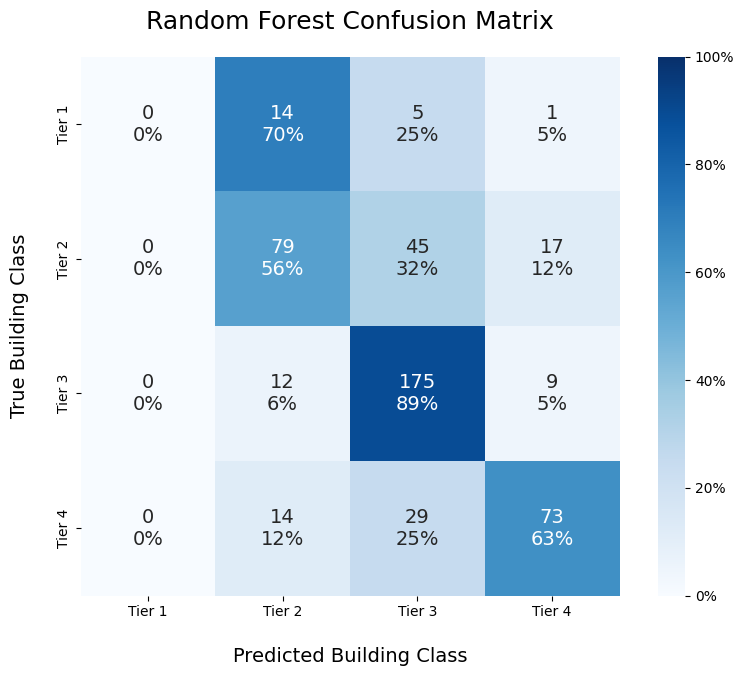

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_clf.classes_)
logger.info("Confusion Matrix:\n%s", cm)

# Calculate row-wise percentages
cm_percentage = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

# Plotting the confusion matrix using seaborn
cm_df = pd.DataFrame(cm, index=best_clf.classes_, columns=best_clf.classes_)
cm_percentage_df = pd.DataFrame(
    cm_percentage, index=best_clf.classes_, columns=best_clf.classes_
)

plt.figure(figsize=(10, 7))

group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.0f}%".format(value) for value in cm_percentage.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(cm.shape)

ax = sns.heatmap(
    cm_percentage_df,
    annot=labels,
    fmt="",
    cmap="Blues",
    square=True,
    annot_kws={"size": 14},
    vmin=0,
    vmax=100,
)

# Customize the title and axis labels with padding and increased font size
ax.set_title("Random Forest Confusion Matrix", pad=20, fontsize=18)
ax.set_xlabel("Predicted Building Class", labelpad=20, fontsize=14)
ax.set_ylabel("True Building Class", labelpad=20, fontsize=14)

# Customize the color bar to show percentages
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}%"))

plt.show()

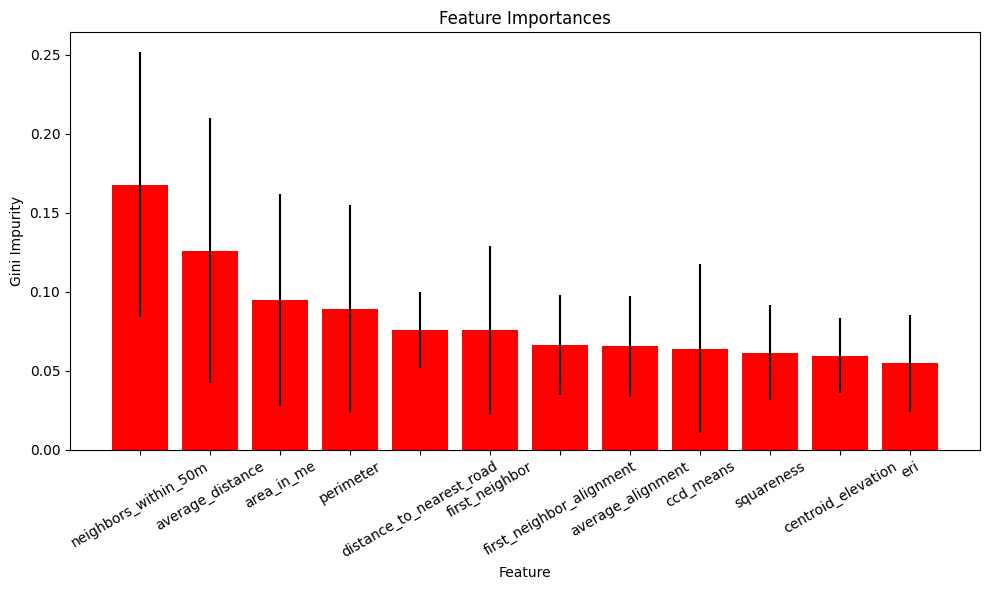

In [16]:
# Get feature importances from the model with reduced features
feature_importances = best_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_clf.estimators_], axis=0)

# Sort the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(optimal_num_features), feature_importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(optimal_num_features), np.array(X.columns)[rfe.support_][indices], rotation=30)
plt.xlim([-1, optimal_num_features])
plt.xlabel("Feature")
plt.ylabel("Gini Impurity")
plt.tight_layout()
plt.show()

In [14]:
# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': np.array(X.columns)[rfe.support_][indices],
    'Gini Impurity': feature_importances[indices]
})

# Sort the DataFrame by importance in descending order
feature_importance_df.sort_values(by='Gini Impurity', inplace=True, ascending=False)

# Print the feature importances
print(feature_importance_df)

                     Feature  Gini Impurity
0       neighbors_within_50m       0.167813
1           average_distance       0.126047
2                 area_in_me       0.094787
3                  perimeter       0.088983
4   distance_to_nearest_road       0.075833
5             first_neighbor       0.075740
6   first_neighbor_alignment       0.066184
7          average_alignment       0.065309
8                  ccd_means       0.063758
9                 squareness       0.061419
10        centroid_elevation       0.059529
11                       eri       0.054598


In [15]:
# Export the model to a file
dump(best_clf, 'datafiles/results/Random Forest/random_forest_model.joblib')

# Export predictions to a file
dump(y_pred, 'datafiles/results/Random Forest/random_forest_predictions.joblib')

# Export tests to a file
dump(y_test, 'datafiles/results/Random Forest/random_forest_tests.joblib')

# Export training results
results = {
    'best_params': grid_search.best_params_,
    'accuracy': accuracy,
    'feature_importances': feature_importance_df.to_dict()
}
with open('datafiles/results/Random Forest/rf_model_results.json', 'w') as f:
    json.dump(results, f)